 Load Libraries

In [29]:
import pandas as pd
import re
from hazm import Normalizer, word_tokenize, stopwords_list, Lemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

 Load and preprocess dataset

In [31]:
df = pd.read_csv("/content/drive/MyDrive/projects/Persian-classifier/data/main_news.csv")
print(df.shape)
print(df.info())
df.head()

(13457, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13457 entries, 0 to 13456
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   13457 non-null  int64 
 1   title        13457 non-null  object
 2   description  13457 non-null  object
 3   image        13402 non-null  object
 4   site         13457 non-null  object
 5   link         13457 non-null  object
 6   tags         13455 non-null  object
dtypes: int64(1), object(6)
memory usage: 736.1+ KB
None


,Unnamed: 0,title,description,image,site,link,tags
0,0,روایتی از تحصیل زیرسقف‌های لرزان و سرمای سوزان...,گروه استان‌ها- دانش‌آموزان مدرسه روستای کَهنان...,https://newsmedia.tasnimnews.com/Tasnim/Upload...,tasnim,https://tn.ai/2205110,استانها
1,1,انقلابی سرشناس بحرین در گفت‌وگو با تسنیم: مردم...,گروه استان‌ها ــ انقلابی سرشناس بحرین با بیان ...,https://newsmedia.tasnimnews.com/Tasnim/Upload...,tasnim,https://tn.ai/2206602,استانها
2,2,‌زندگی مردم در شهر قم ‌جریان دارد / پیشگیری در...,گروه استان‌ها ــ با اعلام شیوع ویروس کرونا در ...,https://newsmedia.tasnimnews.com/Tasnim/Upload...,tasnim,https://tn.ai/2210511,استانها
3,3,درگیر شایعات نشوید؛ نتیجه آزمایش افراد مشکوک ب...,گروه استان‌ها- رئیس دانشگاه علوم پزشکی استان ا...,https://newsmedia.tasnimnews.com/Tasnim/Upload...,tasnim,https://tn.ai/2210539,استانها
4,4,واکنش &quot;پروفسور کرمی&quot; به دروغ‌پراکنی ...,یک متخصص بیوتکنولوژی پزشکی با بیان اینکه مرگ‌و...,https://newsmedia.tasnimnews.com/Tasnim/Upload...,tasnim,https://tn.ai/2210606,اجتماعی


In [32]:
df.drop(columns=['Unnamed: 0', 'image', 'link', 'site'], inplace=True)
df['text'] = df['title'] + ' ' + df['description'] #Combine title and description
df.drop(columns=['title', 'description'], inplace=True)
df.dropna(inplace=True) # Remove missing values

In [9]:
print(df.isnull().sum())
print(df['tags'].value_counts())

tags    0
text    0
dtype: int64
tags
بایگانی                      1944
جهان                         1831
ایران                        1304
بین الملل                    1047
سیاسی                        1003
                             ... 
بین الملل > گزارش و تحلیل       1
ورزشی > توپ و تور               1
استان ها > اردبیل               1
استان ها > یزد                  1
استان ها > ایلام                1
Name: count, Length: 101, dtype: int64


Simplify and remap labels

In [33]:
new_label_map = {
    'فرهنگ و هنر': 'فرهنگ', 'فرهنگی': 'فرهنگ', 'فرهنگی و هنری': 'فرهنگ',
    'اقتصاد': 'اقتصاد', 'اقتصاد ایران': 'اقتصاد', 'اقتصادی': 'اقتصاد', 'بازار': 'اقتصاد',
    'ورزشی': 'ورزش', 'ورزش': 'ورزش',
    'ایران': 'سیاست', 'ايران': 'سیاست', 'سیاسی': 'سیاست',
    'جهان': 'بین‌الملل', 'بین الملل': 'بین‌الملل', 'الشرق الأوسط': 'بین‌الملل',
    'اجتماعی': 'اجتماعی', 'شبکه‌های اجتماعی': 'اجتماعی', 'استانها': 'اجتماعی', 'استان‌ها': 'اجتماعی',
    'دانش و فناوری': 'تکنولوژی', 'دانش و محیط زیست': 'تکنولوژی', 'علمی و دانشگاهی': 'تکنولوژی',
    'آلمان': 'بین‌الملل', 'دویچه وله': 'بین‌الملل', 'دوره‌های زبان آلمانی': 'بین‌الملل', 'آلمانی پیش‌رفته': 'بین‌الملل',
    'خبرخوان': 'بایگانی', 'NRS-Import': 'بایگانی', 'عکس': 'بایگانی', 'رسانه‌ها': 'بایگانی',
    'گرافیک': 'بایگانی', 'ایسنا+': 'بایگانی', 'گوناگون': 'بایگانی', 'ویدئو': 'بایگانی', 'دیدگاه': 'بایگانی',
    'Community D': 'بایگانی'
}

def simplify_label(label):
    return label.split('>')[0].strip()

def remap_label(label):
    return new_label_map.get(label, 'بایگانی')

df['tags'] = df['tags'].apply(simplify_label).apply(remap_label)

Split into main (non-baygani) and baygani datasets

In [34]:
df_main = df[df['tags'] != 'بایگانی'].copy()
df_baygani = df[df['tags'] == 'بایگانی'].copy()

Text preprocessing: normalization, tokenization, stopword removal, lemmatization

In [35]:
normalizer = Normalizer()
lemmatizer = Lemmatizer()
stopwords = set(stopwords_list())
custom_stopwords = {'ایران', 'کشور', 'تهران', 'گزارش', 'خبر', 'امروز', 'دیروز'}
stopwords.update(custom_stopwords)

def clean_text(text):
    text = normalizer.normalize(text)
    text = re.sub(r'<[^>]+>|http\S+|www\S+|[A-Za-z0-9%_=/<>:";!?()\[\]{}|@#$^&*~`+\\\-]|[^\u0600-\u06FF\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords]
    return ' '.join(tokens)

df_main['text_clean'] = df_main['text'].apply(clean_text)
df_baygani['text_clean'] = df_baygani['text'].apply(clean_text)

Initial model to reclassify baygani samples

In [36]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=2)
X_main = vectorizer.fit_transform(df_main['text_clean'])
y_main = df_main['tags']
X_train, X_test, y_train, y_test = train_test_split(X_main, y_main, test_size=0.2, random_state=42, stratify=y_main)
svc = LinearSVC(class_weight='balanced', max_iter=10000, C=1.0, random_state=42)
svc.fit(X_train, y_train)
print("Initial Model Performance:\n", classification_report(y_test, svc.predict(X_test)))

Initial Model Performance:
               precision    recall  f1-score   support

     اجتماعی       0.87      0.85      0.86       351
      اقتصاد       0.76      0.90      0.82       201
   بین‌الملل       0.89      0.90      0.89       661
    تکنولوژی       0.73      0.79      0.76        80
       سیاست       0.90      0.86      0.88       860
       فرهنگ       0.82      0.84      0.83        67
        ورزش       0.86      0.94      0.90        32

    accuracy                           0.87      2252
   macro avg       0.83      0.87      0.85      2252
weighted avg       0.87      0.87      0.87      2252



Reclassify baygani samples

In [37]:
X_baygani = vectorizer.transform(df_baygani['text_clean'])
df_baygani['tags'] = svc.predict(X_baygani)

Combine datasets

In [38]:
df_final = pd.concat([df_main, df_baygani], ignore_index=True)
df_final.to_csv("news_dataset_with_reclassified_baygani.csv", index=False)
print("Final Dataset Shape:", df_final.shape)
print("Label Distribution:\n", df_final['tags'].value_counts())

Final Dataset Shape: (13455, 3)
Label Distribution:
 tags
سیاست        4853
بین‌الملل    4139
اجتماعی      2129
اقتصاد       1292
تکنولوژی      441
فرهنگ         426
ورزش          175
Name: count, dtype: int64


 Final vectorization

In [39]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=2, max_df=0.85)
X = vectorizer.fit_transform(df_final['text_clean'])
y = df_final['tags']

Balance classes with SMOTE

In [45]:
class_counts = y.value_counts()
minority_classes = class_counts[class_counts < 2000].index
sampling_strategy = {cls: 2000 for cls in minority_classes}
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
print("Shape after SMOTE:", X_resampled.shape)
print("Resampled Label Distribution:\n", pd.Series(y_resampled).value_counts())

Shape after SMOTE: (19121, 5000)
Resampled Label Distribution:
 tags
سیاست        4853
بین‌الملل    4139
اجتماعی      2129
اقتصاد       2000
فرهنگ        2000
ورزش         2000
تکنولوژی     2000
Name: count, dtype: int64


Train-test split

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

Model training with hyperparameter tuning

In [47]:
param_grid_svc = {'C': [0.8, 1, 1.2]}
grid_svc = GridSearchCV(LinearSVC(class_weight='balanced', max_iter=10000, random_state=42), param_grid_svc, cv=5, scoring='accuracy', n_jobs=-1)
grid_svc.fit(X_train, y_train)
best_model = grid_svc.best_estimator_
print("Best LinearSVC Parameters:", grid_svc.best_params_)
print("Best LinearSVC CV Score:", grid_svc.best_score_)

Best LinearSVC Parameters: {'C': 1.2}
Best LinearSVC CV Score: 0.91095731656507


Evaluation

In [48]:
y_pred = best_model.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)
print("\nClassification Report:\n", pd.DataFrame(report).transpose())


Classification Report:
               precision    recall  f1-score      support
اجتماعی        0.882952  0.814554  0.847375   426.000000
اقتصاد         0.854839  0.927500  0.889688   400.000000
بین‌الملل      0.906404  0.888889  0.897561   828.000000
تکنولوژی       0.914153  0.985000  0.948255   400.000000
سیاست          0.918542  0.882595  0.900210   971.000000
فرهنگ          0.954436  0.995000  0.974296   400.000000
ورزش           0.987654  1.000000  0.993789   400.000000
accuracy       0.915817  0.915817  0.915817     0.915817
macro avg      0.916997  0.927648  0.921596  3825.000000
weighted avg   0.915811  0.915817  0.915210  3825.000000


Confusion matrix

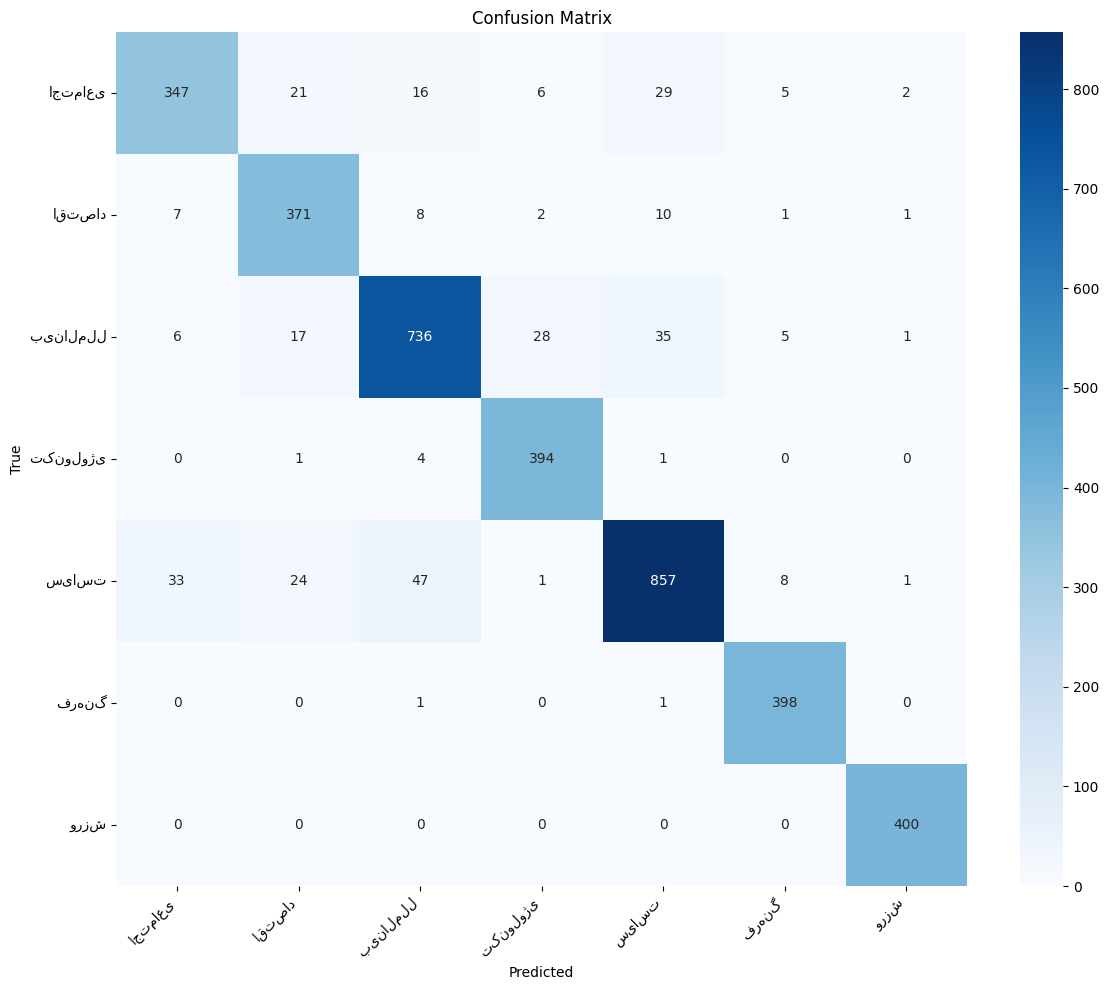

In [49]:
labels = sorted(df_final['tags'].unique())
cm = confusion_matrix(y_test, y_pred, labels=labels)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

 F1-scores per class

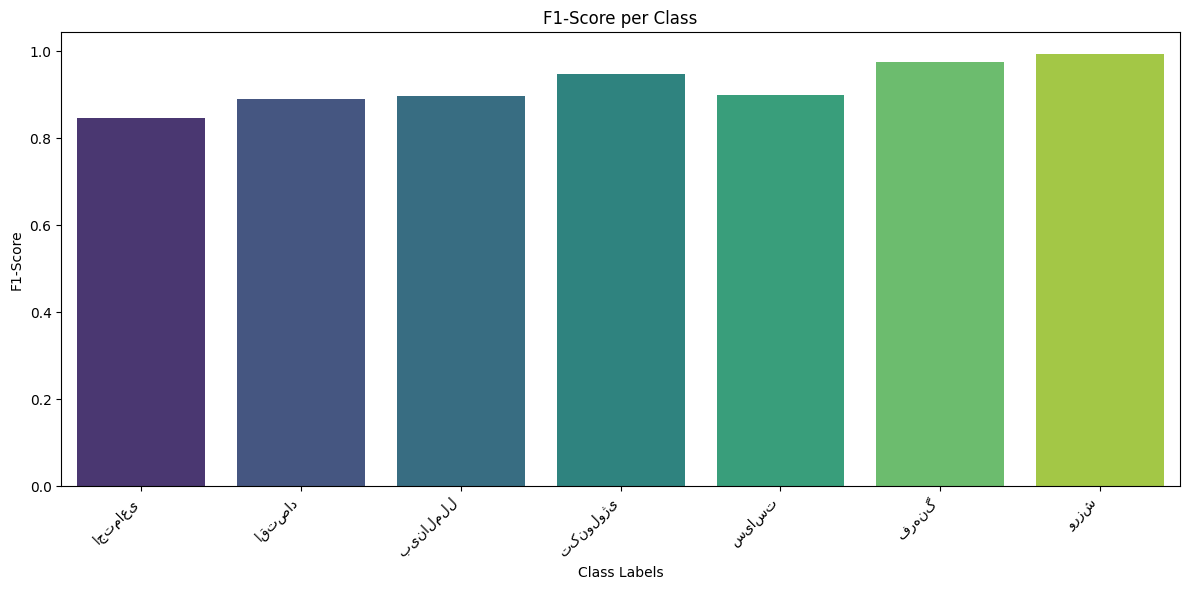

In [51]:
f1_scores = {k: v['f1-score'] for k, v in report.items() if k in labels}
plt.figure(figsize=(12, 6))
sns.barplot(x=list(f1_scores.keys()), y=list(f1_scores.values()), hue=list(f1_scores.keys()), palette='viridis', legend=False)
plt.title('F1-Score per Class')
plt.xlabel('Class Labels')
plt.ylabel('F1-Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('f1_scores.png')
plt.show()

Print key metrics

In [52]:
print(f"\nAccuracy: {report['accuracy']:.2f}")
print(f"Macro Avg F1-score: {report['macro avg']['f1-score']:.2f}")
print(f"Weighted Avg F1-score: {report['weighted avg']['f1-score']:.2f}")


Accuracy: 0.92
Macro Avg F1-score: 0.92
Weighted Avg F1-score: 0.92
